In [12]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [5]:
import altair as alt
import json
import os
import pandas as pd
from pandas.io.json import json_normalize

# Get Data

## File Paths

In [6]:
HOME_DIR = os.getcwd().split('/notebooks')[0]
DATA_DIR = os.path.join(HOME_DIR, 'data')

fe_toronto_json_path = os.path.join(DATA_DIR, 'city/toronto/festivals-and-events_toronto.json')

## Festival & Events Toronto Data

### Get data

In [7]:
with open(fe_toronto_json_path, 'r') as read_file:
    fe_toronto_json = json.load(read_file)

fe_toronto_json = [calender_event_object['calEvent'] for calender_event_object in fe_toronto_json]
fe_toronto = json_normalize(fe_toronto_json)

### Format data

In [54]:
# convert time related columns to datetime
time_columns = [ 
    col_name 
    for col_name in fe_toronto.columns.values 
    if (('Date' in col_name) or ('Time' in col_name)) and (col_name != 'weeklyDates')
]

for col_name in time_columns:
    fe_toronto[col_name] = pd.to_datetime(fe_toronto[col_name])

# Data Exploration

## Time

In [66]:
#fe_toronto.columns.values

In [67]:
#fe_toronto[['admin.postedTimestamp']].dropna()

### Check if all event records have start & end dates

In [8]:
fe_toronto.shape == fe_toronto.dropna(subset=['startDate', 'endDate']).shape

True

### Explore range & descriptive statistics of events w.r.t time

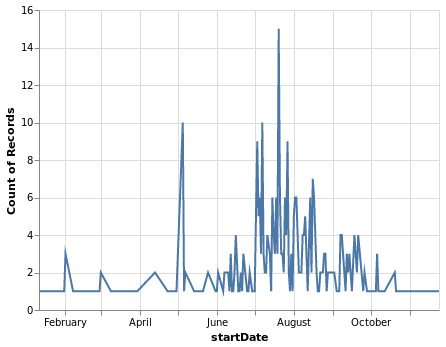

In [65]:
(alt
 .Chart(fe_toronto)
 .mark_line()
 .encode(
     y='count(startDate)',
     x='startDate'
 )
)